In [85]:
import numpy as np
import scipy as sp

In [ ]:
def get_Hessian(Weights, Biases, x):
  Weights = np.array(Weights)
  Biases = np.array(Biases)
  x = np.array(x)
  N = len(Biases)
  Hessian = np.zeros((N,N))
  Hessian[0,0] = 1
  for i in range(N):
    for j in range(N):
      if i != j:
        Hessian[i][j] = -(1/2) * (Weights[i][j]+Weights[j][i]) * (dersigmoid(x[i])) * (dersigmoid(x[j]))
      else:
        Hessian[i,i] = 1 - Biases[i] * second_dersigmoid(x[i])
        weights_term = 0
        for k in range(N):
          if k != i:
            weights_term-= (1/2) * (Weights[i][k]) * second_dersigmoid(x[i]) * sigmoid(x[k])
  return Hessian

def Find_eigs(Hes_matrix):
  eigs = np.linalg.eigvals(Hes_matrix)
  greater = 0
  less = 0
  zeros = 0
  for i in range(len(eigs)):
    if eigs[i] < 1e-6 and eigs[i] > -1e-6:
      zeros+=1
    elif eigs[i] > 0:
      greater += 1
    else:
      less += 1
  return less, zeros, greater


In [89]:
import torch
    
class EquationSolver:
    def __init__(self, states, weights, biases):
        self.states = states
        self.weights = weights
        self.biases = biases
        self.layer_sizes = [len(s) for s in states]
        self.total_size = sum(self.layer_sizes) - self.layer_sizes[0]  # Exclude the input layer size
    
    def activation(self,x, grad=False):
        if grad:
            # Calculate the gradient of the clamping function
            return torch.where((x > 0) & (x < 1), torch.ones_like(x), torch.zeros_like(x))
        elif not grad:
            return torch.clamp(x, min=0, max=1)
    
    def create_equations(self, hy_array):
        grads = None
        start = 0
        end = 0
        
        for i in range(1,len(self.states)):
            # Calculate values for equation components 
            end += self.layer_sizes[i]
            temp = hy_array[start:end]
            self.states[i] = torch.tensor(temp).float()
            start = end

        # Hidden layers update
        for i in range(1, len(self.layer_sizes)-1):
            # Calculate values for equation components
            a_prev = self.activation(self.states[i-1])
            a_next = self.activation(self.states[i+1])
            
            feedforward = a_prev @ self.weights[i-1]
            feedback = a_next @ self.weights[i].T
            bias_term = self.biases[i-1]
            
            # Calculate gradient
            grad = self.activation(self.states[i], grad=True) * (feedforward + feedback + bias_term) - self.states[i]
            if grads is None:
                grads = grad.numpy()
            else:
                grads = np.concatenate((grads, grad.numpy()), axis=0)

        # Last layer update
        a_prev = self.activation(self.states[-2])
        feedforward = a_prev @ self.weights[-1]
        bias_term = self.biases[-1]
        
        grad = self.activation(self.states[-1], grad=True) * (feedforward + bias_term) - self.states[-1]
        if grads is None:
            grads = grad.numpy()
        else:
            grads = np.concatenate((grads, grad.numpy()), axis=0)

                  
        return grads 
    
    def solve(self,Tests = 1):
        
        equations = self.create_equations
        solutions = []
        n = self.total_size
        for i in range(Tests):
            solution = sp.optimize.fsolve(equations, 100 * np.random.uniform(low=-1,high=1,size=n))
            if not any(np.allclose(solution, s, atol=1e-6) for s in solutions):
                solutions.append(solution)
        return solutions
    
    def verify(self,ans):        
        # Create equations for the current state
        verifffy = []
        for i in range(len(ans)):
            equations = self.create_equations(ans[i])
            
            verifffy.append(np.allclose(equations, 0, atol=1e-6))

        ver_count = {}
        for i in verifffy:
            if i in ver_count:
                ver_count[i] += 1
            else:
                ver_count[i] = 1
        print(ver_count)
        
        return verifffy
    
    def energy(self,states):
    
        energy = 0.0
        weights = self.weights
        biases = self.biases
        
        # Calculate the energy according to the new formulation
        # squared_norm: for each layer, sum of squares of each row, then sum over layers.
        squared_norm = sum([(s * s).sum(dim=0) for s in states]) / 2.0

        # linear_terms: for each layer, compute dot(layer, bias).
        linear_terms = -sum([torch.sum(states[i+1] * biases[i]) for i in range(len(biases))])

        # quadratic_terms: for each adjacent pair of layers.
        quadratic_terms = -sum([
            ((states[i] @ weights[i]) * states[i+1]).sum(dim=0)
            for i in range(len(weights))
        ])

        energy = squared_norm + linear_terms + quadratic_terms
            
        return energy

In [ ]:
# 2 Circles Dataset 
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from model import EnergyBasedModel as EBM

import matplotlib.pyplot as plt

def generate_3d_circle_data(center, radius, normal_vector, num_points=100):
    """
    Generate points on a 3D circle with given center, radius, and normal vector.
    
    Parameters:
    - center: 3D coordinates of circle center
    - radius: radius of the circle
    - normal_vector: normal vector to the circle plane
    - num_points: number of points to generate
    
    Returns:
    - points on the circle
    """
    # Normalize the normal vector
    normal = np.array(normal_vector)
    normal = normal / np.linalg.norm(normal)
    
    # Find two orthogonal vectors in the circle plane
    if np.allclose(normal, [1, 0, 0]):
        v1 = np.array([0, 1, 0])
    else:
        v1 = np.cross(normal, [1, 0, 0])
        v1 = v1 / np.linalg.norm(v1)
    
    v2 = np.cross(normal, v1)
    v2 = v2 / np.linalg.norm(v2)
    
    # Generate circle points
    theta = np.linspace(0, 2 * np.pi, num_points)
    circle_points = center + radius * (np.outer(np.cos(theta), v1) + np.outer(np.sin(theta), v2))
    
    return circle_points

# Create the dataset
def create_circles_dataset(num_points=100):
    # Circle 1: centered at the origin, on the xy-plane
    center1 = np.array([0, 0, 0])
    radius1 = 1.0
    normal1 = np.array([0, 0, 1])  # Normal to xy-plane
    
    # Circle 2: centered at (0, 1, 0), on the yz-plane (perpendicular to Circle 1)
    center2 = np.array([0, 1, 0])
    radius2 = 1.0
    normal2 = np.array([1, 0, 0])  # Normal to yz-plane
    
    # Generate points
    circle1_points = generate_3d_circle_data(center1, radius1, normal1, num_points)
    circle2_points = generate_3d_circle_data(center2, radius2, normal2, num_points)
    
    # Combine into a dataset with labels
    X = np.vstack([circle1_points, circle2_points])
    y = np.array([0] * num_points + [1] * num_points)
    
    return X, y

# Generate the dataset
X, y = create_circles_dataset(num_points=200)

# Visualize
def visualize_circles(X, y):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot points for each circle
    colors = ['blue', 'red']
    for i, color in enumerate(colors):
        mask = (y == i)
        ax.scatter(X[mask, 0], X[mask, 1], X[mask, 2], c=color, s=10, label=f'Circle {i+1}')
    
    # Add circle centers
    centers = [np.array([0, 0, 0]), np.array([0, 1, 0])]
    ax.scatter([c[0] for c in centers], [c[1] for c in centers], [c[2] for c in centers], 
               c='black', s=100, marker='x', label='Centers')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Two 3D Circles')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Visualize the dataset
visualize_circles(X, y)
# Test, train split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
import torch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create a DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=False)

# Define the model 
model_config = {
    'input_size': 3,  # 3D input
    'hidden_sizes': [32, 2],  # Hidden layer sizes
    'beta': 0.2,  # Temperature parameter
    'dt': 0.05,   # Step size
    'n_steps': 20 # Number of steps
}

model = EBM(
    input_size=model_config['input_size'],
    hidden_sizes=model_config['hidden_sizes'],# Number of stepshidden_sizes'],
    beta=model_config['beta'],
    dt=model_config['dt'],
    optimizer=None,  # Optimizer will be set separately
    n_steps=model_config['n_steps']
)

# Define the optimizer
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Set the optimizer in the model
model.optimizer = optimizer
# Training loop
num_epochs = 10
model.debug = False
for epoch in range(num_epochs):
    model.train()
    targets = []
    preds = []
    for batch_X, batch_y in train_loader:
        # optimizer.zero_grad()
        output = model(batch_X,batch_y)
        preds.append(output)
        targets.append(batch_y)
    accuracy = (torch.cat(preds).argmax(dim=1) == torch.cat(targets)).float().mean()
    print(f"Epoch {epoch+1}/{num_epochs}, Accuracy: {accuracy.item():.4f}")

for batch_X, batch_y in test_loader:
    with torch.no_grad():
        output = model(batch_X)
        preds.append(output)
        targets.append(batch_y)
accuracy = (torch.cat(preds).argmax(dim=1) == torch.cat(targets)).float().mean()
print(f"Test Accuracy: {accuracy.item():.4f}")


In [90]:
W = [w.detach() for w in model.weights]
B = [b.detach() for b in model.biases]
S = model.states
# Only one state from the batch
S = [s[0].detach() for s in S]
eq = EquationSolver(S,W,B)
ans=eq.solve(Tests=1000)

/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


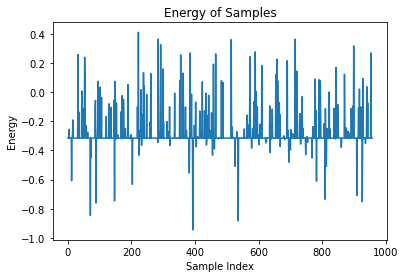

In [91]:
energy = []
for i in range(len(ans)):
    S[1] = torch.tensor(ans[i][:32]).float()
    S[2] = torch.tensor(ans[i][32:]).float()
    temp = eq.energy(S)
    energy.append(temp)

import matplotlib.pyplot as plt
plt.plot(energy)
plt.xlabel('Sample Index')
plt.ylabel('Energy')
plt.title('Energy of Samples')
plt.show()